In [44]:
from keras.layers import Permute, Dense, Conv1D, BatchNormalization, Activation, Dropout, Flatten, Reshape, LSTM, Conv2D, MaxPooling2D, GRU
from keras.models import Model, Sequential
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots

import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

es = EarlyStopping(monitor='val_acc', mode='max', min_delta=.005, patience=10, restore_best_weights=True)

In [21]:
X_train = np.load("data\X_train_valid.npy")
y_train = np.load("data\y_train_valid.npy")

X_test = np.load("data\X_test.npy")
y_test = np.load("data\y_test.npy")

person_train = np.ravel(np.load("data\person_train_valid.npy"))
person_test = np.ravel(np.load("data\person_test.npy"))

In [22]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]
    
    if len(loss_list) == 0:
        print('Loss is missing in history')
        return 
    
    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)
    
    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:    
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [23]:
def get_train_val_split(data, targets, person_data, val_size=0.2):
    
    sss = StratifiedShuffleSplit(n_splits=2, test_size=0.2, random_state=42)
    sss.get_n_splits(data, targets)

    X = data
    y = targets
    p = person_data

    for train_index, val_index in sss.split(data, targets):
        X_train, X_val = X[train_index], X[val_index]
        y_train, y_val = y[train_index], y[val_index]
        person_train, person_val = p[train_index], p[val_index]
        
    return X_train, y_train, X_val, y_val, person_train, person_val

# X_train, y_train, X_val, y_val, person_train, person_val = get_train_val_split(X_train, y_train, person_train)
# print(X_train.shape, y_train.shape, X_val.shape, y_val.shape, person_train.shape, person_val.shape)

def clean_data(X, y):
    # REMOVE EOG DATA
    X = X[:,:-3,:]
    # RESET Y VALUES and ONE HOT ENCODE
    y = y % 769.0
    print('Data cleaned... X shape = {}, y shape = {}'.format(X.shape, y.shape))
    return X, y

# X_train, y_train = clean_data(X_train, y_train)

def get_train_val_test_for_subject(X_train,
                                   y_train,
                                   X_val, 
                                   y_val,
                                   X_test, 
                                   y_test,
                                   person_train, 
                                   person_val, 
                                   person_test, 
                                   subject=0):
    
    X_train = np.squeeze(X_train[np.argwhere(person_train == subject)])
    y_train = np.squeeze(y_train[np.argwhere(person_train == subject)])
    X_val = np.squeeze(X_val[np.argwhere(person_val == subject)])
    y_val = np.squeeze(y_val[np.argwhere(person_val == subject)])
    X_test = np.squeeze(X_test[np.argwhere(person_test == subject)])
    y_test = np.squeeze(y_test[np.argwhere(person_test == subject)])
    
    print('Data for subject {}'.format(subject))
    print('X_train shape', X_train.shape)
    print('y_train shape', y_train.shape)
    print('X_val shape', X_val.shape)
    print('y_val shape', y_val.shape)
    print('X_test shape', X_test.shape)
    print('y_test shape', y_test.shape)
    
    return X_train, y_train, X_val, y_val, X_test, y_test

# X_train_0, y_train_0, X_val_0, y_val_0, X_test_0, y_test_0 = get_train_val_test_for_subject(X_train, y_train,
#                                                                                             X_val, y_val,
#                                                                                             X_test, y_test,
#                                                                                             person_train, 
#                                                                                             person_val, 
#                                                                                             person_test,
#                                                                                             subject=0)

In [24]:
X_train, y_train, X_val, y_val, person_train, person_val = get_train_val_split(X_train, y_train, person_train)

X_train, y_train = clean_data(X_train, y_train)
X_val, y_val = clean_data(X_val, y_val)
X_test, y_test = clean_data(X_test, y_test)

# Targting one specific subject
X_train_0, y_train_0, X_val_0, y_val_0, X_test_0, y_test_0 = get_train_val_test_for_subject(X_train, y_train,
                                                                                            X_val, y_val,
                                                                                            X_test, y_test,
                                                                                            person_train, 
                                                                                            person_val, 
                                                                                            person_test,
                                                                                            subject=0)

# X_train = scale_then_smooth(X_train)
# X_val = scale_then_smooth(X_val)
# X_test = scale_then_smooth(X_test)

Data cleaned... X shape = (1692, 22, 1000), y shape = (1692,)
Data cleaned... X shape = (423, 22, 1000), y shape = (423,)
Data cleaned... X shape = (443, 22, 1000), y shape = (443,)
Data for subject 0
X_train shape (190, 22, 1000)
y_train shape (190,)
X_val shape (47, 22, 1000)
y_val shape (47,)
X_test shape (50, 22, 1000)
y_test shape (50,)


### Simple LSTM

Train on 1692 samples, validate on 423 samples
Epoch 1/20
1692/1692 [==============================] - 30s 18ms/step - loss: 1.4508 - acc: 0.2595 - val_loss: 1.4346 - val_acc: 0.2293
Epoch 2/20
1692/1692 [==============================] - 30s 17ms/step - loss: 1.3894 - acc: 0.2920 - val_loss: 1.4272 - val_acc: 0.2340
Epoch 3/20
1692/1692 [==============================] - 29s 17ms/step - loss: 1.3643 - acc: 0.3262 - val_loss: 1.4307 - val_acc: 0.2270
Epoch 4/20
1692/1692 [==============================] - 29s 17ms/step - loss: 1.3519 - acc: 0.3422 - val_loss: 1.4292 - val_acc: 0.2317
Epoch 5/20
1692/1692 [==============================] - 28s 17ms/step - loss: 1.3397 - acc: 0.3333 - val_loss: 1.4324 - val_acc: 0.2435
Epoch 6/20
1692/1692 [==============================] - 30s 18ms/step - loss: 1.3276 - acc: 0.3641 - val_loss: 1.4269 - val_acc: 0.2577
Epoch 7/20
1692/1692 [==============================] - 30s 18ms/step - loss: 1.3111 - acc: 0.3865 - val_loss: 1.4331 - val_acc: 0.2459
E

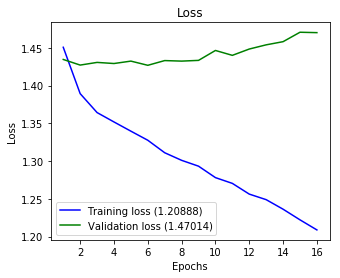

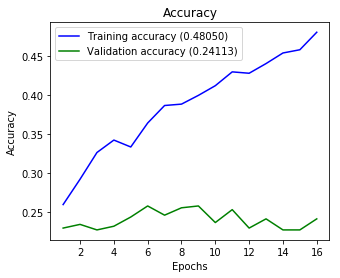

In [16]:
mc = ModelCheckpoint('best_simple_LSTM.h5', monitor='val_acc', mode='max', verbose=0, save_best_only=True)

# train_x, train_y = X_train_0, y_train_0
# val_x, val_y = X_val_0, y_val_0
# test_x, test_y = X_test_0, y_test_0 

train_x, train_y = X_train, y_train
val_x, val_y = X_val, y_val
test_x, test_y = X_test, y_test

model = Sequential()

model.add(LSTM(50, input_shape = (1000,22)))
model.add(Dense(units = 4, activation = 'softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

train_x = train_x.transpose((0,2,1))
val_x = val_x.transpose((0,2,1))
test_x = test_x.transpose((0,2,1))

history = model.fit(train_x, train_y, epochs=20, batch_size=32, validation_data = (val_x, val_y), callbacks=[es, mc])
score = model.evaluate(test_x, test_y, batch_size=32)
print(score)

plot_history(history)

### Simple GRU

Train on 1692 samples, validate on 423 samples
Epoch 1/20
1692/1692 [==============================] - 49s 29ms/step - loss: 1.5397 - acc: 0.2441 - val_loss: 1.4694 - val_acc: 0.2411
Epoch 2/20
1692/1692 [==============================] - 43s 25ms/step - loss: 1.4394 - acc: 0.2831 - val_loss: 1.4666 - val_acc: 0.2340
Epoch 3/20
1692/1692 [==============================] - 44s 26ms/step - loss: 1.3926 - acc: 0.3144 - val_loss: 1.4748 - val_acc: 0.2530
Epoch 4/20
1692/1692 [==============================] - 44s 26ms/step - loss: 1.3573 - acc: 0.3381 - val_loss: 1.4718 - val_acc: 0.2388
Epoch 5/20
1692/1692 [==============================] - 41s 24ms/step - loss: 1.3221 - acc: 0.3777 - val_loss: 1.4864 - val_acc: 0.2270
Epoch 6/20
1692/1692 [==============================] - 45s 27ms/step - loss: 1.2966 - acc: 0.4072 - val_loss: 1.4861 - val_acc: 0.2317
Epoch 7/20
1692/1692 [==============================] - 43s 25ms/step - loss: 1.2732 - acc: 0.4226 - val_loss: 1.4984 - val_acc: 0.2080
E

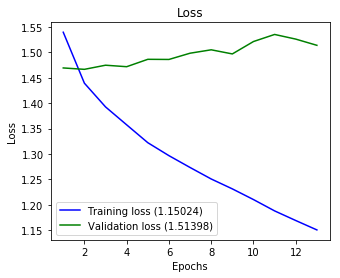

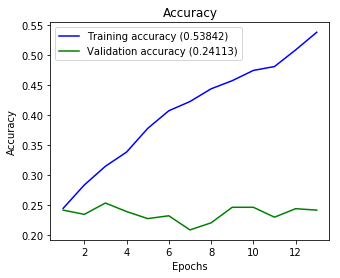

In [46]:
mc = ModelCheckpoint('best_simple_LSTM.h5', monitor='val_acc', mode='max', verbose=0, save_best_only=True)

# train_x, train_y = X_train_0, y_train_0
# val_x, val_y = X_val_0, y_val_0
# test_x, test_y = X_test_0, y_test_0 

train_x, train_y = X_train, y_train
val_x, val_y = X_val, y_val
test_x, test_y = X_test, y_test

model = Sequential()

model.add(GRU(50, input_shape = (1000,22)))
model.add(Dense(units = 4, activation = 'softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

train_x = train_x.transpose((0,2,1))
val_x = val_x.transpose((0,2,1))
test_x = test_x.transpose((0,2,1))

history = model.fit(train_x, train_y, epochs=20, batch_size=32, validation_data = (val_x, val_y), callbacks=[es, mc])
score = model.evaluate(test_x, test_y, batch_size=32)
print(score)

plot_history(history)

### LSTM-CONV Hybrid

Train on 1692 samples, validate on 423 samples
Epoch 1/50
1692/1692 [==============================] - 117s 69ms/step - loss: 1.4082 - acc: 0.2441 - val_loss: 1.4059 - val_acc: 0.2506
Epoch 2/50
1692/1692 [==============================] - 109s 64ms/step - loss: 1.3817 - acc: 0.2931 - val_loss: 1.4589 - val_acc: 0.2577
Epoch 3/50
1692/1692 [==============================] - 107s 63ms/step - loss: 1.3826 - acc: 0.2766 - val_loss: 1.5297 - val_acc: 0.2671
Epoch 4/50
1692/1692 [==============================] - 108s 64ms/step - loss: 1.3684 - acc: 0.3150 - val_loss: 1.4010 - val_acc: 0.2908
Epoch 5/50
1692/1692 [==============================] - 106s 63ms/step - loss: 1.3518 - acc: 0.3274 - val_loss: 1.3552 - val_acc: 0.3310
Epoch 6/50
1692/1692 [==============================] - 105s 62ms/step - loss: 1.3349 - acc: 0.3499 - val_loss: 1.3817 - val_acc: 0.3168
Epoch 7/50
1692/1692 [==============================] - 106s 63ms/step - loss: 1.3171 - acc: 0.3853 - val_loss: 1.3693 - val_acc: 0

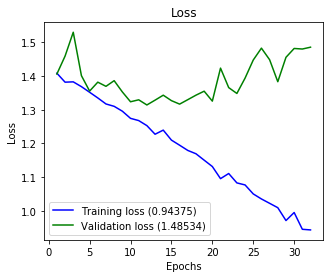

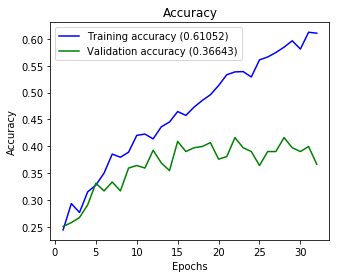

In [49]:
mc = ModelCheckpoint('best_LSTM_CONV_Hybrid.h5', monitor='val_acc', mode='max', verbose=0, save_best_only=True)

# train_x, train_y = X_train_0, y_train_0
# val_x, val_y = X_val_0, y_val_0
# test_x, test_y = X_test_0, y_test_0 

train_x, train_y = X_train, y_train
val_x, val_y = X_val, y_val
test_x, test_y = X_test, y_test

ki = 'glorot_normal'

model = Sequential()

model.add(Permute((2, 1), input_shape=(1000, 22)))
model.add(Reshape((1000, 22, 1)))

model.add(Conv2D(filters=50, kernel_size=(10,1), kernel_initializer = ki, data_format="channels_last"))
model.add(Conv2D(filters=50, kernel_size=(1,22), kernel_initializer = ki ))
model.add(BatchNormalization())
model.add(Activation(activation = 'elu'))
model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
model.add(Dropout(0.5))

# Conv Pool Block 2
model.add(Conv2D(filters = 50, kernel_size = (10,1), activation = 'elu', kernel_initializer = ki))
model.add(BatchNormalization())
model.add(Activation(activation = 'elu'))
model.add(MaxPooling2D(pool_size = (3,1), strides = (3,1)))
model.add(Dropout(0.5))

model.add(Permute((1, 3, 2)))
model.add(Reshape((107, 50)))

# RNN layers
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))

# Dense layers
model.add(Flatten())
model.add(Dense(units=4, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

train_x = train_x.transpose((0,2,1))
val_x = val_x.transpose((0,2,1))
test_x = test_x.transpose((0,2,1))

history = model.fit(train_x, train_y, epochs=50, batch_size=32, validation_data = (val_x, val_y), callbacks=[es, mc])
score = model.evaluate(test_x, test_y, batch_size=32)
print(score)

plot_history(history)

### 3-layer LSTM with 1D Conv

Train on 1692 samples, validate on 423 samples
Epoch 1/20
1692/1692 [==============================] - 147s 87ms/step - loss: 1.3913 - acc: 0.2600 - val_loss: 1.3886 - val_acc: 0.2648
Epoch 2/20
1692/1692 [==============================] - 141s 83ms/step - loss: 1.3798 - acc: 0.2914 - val_loss: 1.4066 - val_acc: 0.2648
Epoch 3/20
1692/1692 [==============================] - 142s 84ms/step - loss: 1.3707 - acc: 0.2996 - val_loss: 1.3984 - val_acc: 0.2648
Epoch 4/20
1692/1692 [==============================] - 140s 83ms/step - loss: 1.3484 - acc: 0.3475 - val_loss: 1.4121 - val_acc: 0.2837
Epoch 5/20
1692/1692 [==============================] - 143s 84ms/step - loss: nan - acc: 0.3191 - val_loss: nan - val_acc: 0.2506
Epoch 6/20
1692/1692 [==============================] - 140s 83ms/step - loss: nan - acc: 0.2500 - val_loss: nan - val_acc: 0.2506
Epoch 7/20
1692/1692 [==============================] - 138s 82ms/step - loss: nan - acc: 0.2500 - val_loss: nan - val_acc: 0.2506
Epoch 8/20
1

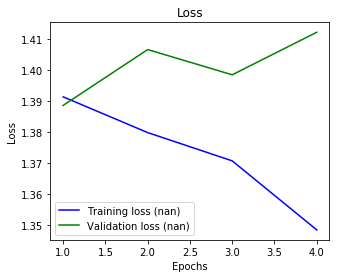

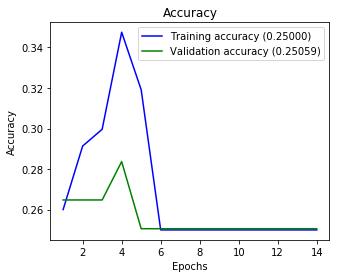

In [47]:
mc = ModelCheckpoint('best_1DConv_3LSTM.h5', monitor='val_acc', mode='max', verbose=0, save_best_only=True)

# train_x, train_y = X_train_0, y_train_0
# val_x, val_y = X_val_0, y_val_0
# test_x, test_y = X_test_0, y_test_0 

train_x, train_y = X_train, y_train
val_x, val_y = X_val, y_val
test_x, test_y = X_test, y_test

model = Sequential()

model.add(Conv1D(filters=50, kernel_size=10, input_shape=(1000, 22), kernel_initializer = 'glorot_normal'))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50, activation = 'relu', return_sequences = True))
model.add(LSTM(50))
model.add(Dense(units = 4, activation = 'softmax'))

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

train_x = train_x.transpose((0,2,1))
val_x = val_x.transpose((0,2,1))
test_x = test_x.transpose((0,2,1))

history = model.fit(train_x, train_y, epochs=50, batch_size=32, validation_data = (val_x, val_y), callbacks=[es, mc])
score = model.evaluate(test_x, test_y, batch_size=32)
print(score)

plot_history(history)